In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Pytorch: Loading Different Architectures

PyTorch provides a convenient way to download pre-trained models using the torchvision package. We can download the AlexNet model from the torchvision package by running the following code:

In [ ]:
import torch
import torchvision.models as models

alexnet = models.alexnet(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The pretrained argument is set to True, indicating that we want to download the pre-trained version of the model.

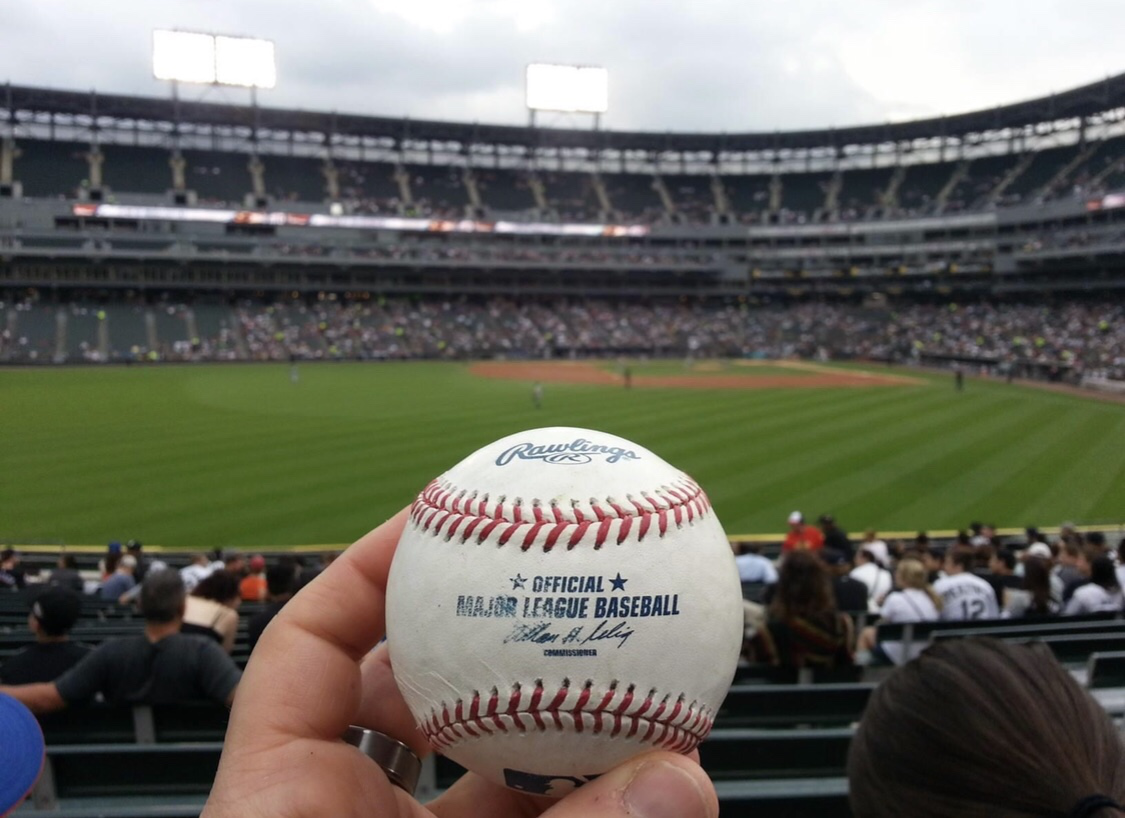

In [ ]:
import requests
from io import BytesIO
from PIL import Image
from torchvision import transforms

# Load and preprocess the image
url = 'https://i.imgur.com/KIEGKka.jpeg'
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert('RGB')
image.show()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
image = preprocess(image)

# Make a prediction using the model
with torch.no_grad():
    output = alexnet(image.unsqueeze(0))


The above code follows:

*   ***transforms.Resize(256)*** - resizes the image so that its smallest dimension is 256 pixels
*    ***transforms.CenterCrop(224)*** - crops the image to a square of size 224x224 pixels
*    ***transforms.ToTensor()*** - converts the image to a PyTorch tensor
*    ***transforms.Normalize()*** - normalizes the image using the mean and standard deviation values for the ImageNet dataset



In [ ]:
import urllib.request, json 

# Load class labels
with urllib.request.urlopen(" https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json") as url:
    class_idx = json.load(url)

# Extract top k predicted classes
k = 5
probs, indices = torch.topk(output, k)
    
# Map indices to class labels
idx_to_class = {int(k): v[1] for k, v in class_idx.items()}
labels = [idx_to_class[i.item()] for i in indices[0]]
    
# Print predicted classes and probabilities
for label, prob in zip(labels, probs[0]):
    print(f'{label}: {prob.item():.4f}')

baseball: 13.6964
ballplayer: 11.1657
airship: 10.5344
golf_ball: 9.9941
airliner: 9.7615


### Transfer Learning based on AlexNet

It is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest. The three major Transfer Learning scenarios look as follows:


1.   ConvNet (e.g. AlexNet, VGGNet, LeNet) as fixed feature extractor

    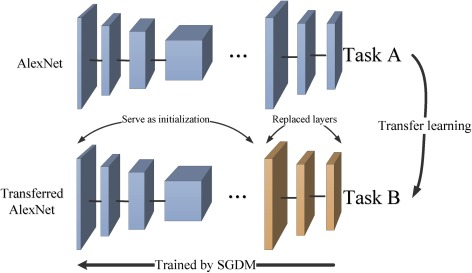

2.   Fine-tuning the ConvNet

    The second strategy is to not only replace and retrain the classifier on top of the ConvNet on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation.

3.   Pretrained models

    Caffe library has a [Model Zoo](https://github.com/BVLC/caffe/wiki/Model-Zoo) where people share their network weights.


### Pytorch Code: AlexNet model on MNIST Data

In [ ]:
from torch import nn
import numpy as np

class TransferFeatures(nn.Module):
    def __init__(self, original_model, classifier, model_name):
        super(TransferFeatures, self).__init__()

        self.features = original_model.features
        print(self.features)
        self.classifier = classifier
        self.modelName = model_name

        # Freeze those weights
        for p in self.features.parameters():
            p.requires_grad = False

    def forward(self, x):
        f = self.features(x)
        # flatten network
        f = f.view(f.size(0), np.prod(f.shape[1:]))
        y = self.classifier(f)
        return y

Load the AlexNet model as well MNIST data and retrain the model with the new data

In [ ]:
from PIL import Image
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torchvision import models
from torchvision import datasets
import torch.optim as optim
from torch.utils.data import Subset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.alexnet(pretrained=True)

classifier = nn.Sequential(
    nn.Dropout(),
    nn.Linear(256 * 6 * 6, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Linear(4096, 10),
)

refit_model = TransferFeatures(model, classifier, 'transfer')

def transform(img):
    img = img.resize((224, 224)).convert('RGB')
    tensor = ToTensor()(img)
    return tensor

train_data = datasets.MNIST(root = 'data',train = True,download=True,transform = transform)
# print(len(complete_data))

# train_data = Subset(complete_data, indices=range(len(complete_data) // 30))
print(len(train_data))

data_loader = torch.utils.data.DataLoader(train_data,batch_size=4,shuffle=True, num_workers=1)
classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(refit_model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):  
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = refit_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
60000


TypeError: ignored

Save the model

In [ ]:
torch.save(refit_model, '/content/drive/MyDrive/fitted.pth')

### Visualize predictions

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torch.utils.data import DataLoader

test_data = datasets.FashionMNIST( root="data",train=False,download=True, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=4, shuffle=True)

was_training = model.training
model.eval()
images_so_far = 0
fig = plt.figure()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(len(test_data)//2, 2, images_so_far)
            ax.axis('off')
            # ax.set_title(f'predicted: {classes[preds[j]]}')
            imshow(inputs.cpu().data[j])

    model.train(mode=was_training)